In [1]:
from wobble.interp import interp
import h5py
import wobble
import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
starid = 'hip54287'
filename = '../data/'+starid+'_e2ds.hdf5'

In [3]:
with h5py.File(filename) as f:
    data = np.log(f['data'][30])
    data_xs = np.log(f['xs'][30])
    ivars = np.copy(f['ivars'][30])
    pipeline_rvs = -1. * np.copy(f['pipeline_rvs'])

In [4]:
for n in range(len(data)):
    data[n] -= wobble.fit_continuum(data_xs[n], data[n], ivars[n])

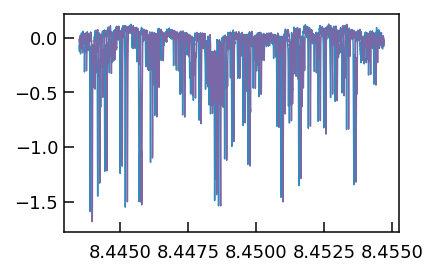

In [5]:
plt.plot(data_xs[0], data[0])
plt.plot(data_xs[5], data[5])

In [6]:
len(data)

75

In [7]:
a = wobble.star(starid+'_e2ds.hdf5', orders=[30])
a.initialize_model(0, 'star')
model_xs, model_ys = a.model_xs_star[0], a.model_ys_star[0]

initializing star model...


In [8]:
np.shape(model_xs)

(6815,)

In [9]:
import tensorflow as tf

In [10]:
T = tf.float64
model_xs_tensor = tf.constant(model_xs, dtype=T)
model_ys_tensor = tf.Variable(model_ys, dtype=T)
data_tensor = tf.constant(data, dtype=T)
xs_tensor = tf.constant(data_xs, dtype=T)
ivars_tensor = tf.constant(ivars, dtype=T)

In [11]:
starting_rvs = pipeline_rvs + np.random.normal(0., 100., len(pipeline_rvs))
rvs_tensor = tf.Variable(starting_rvs, dtype=T)

In [12]:
c = 2.99792458e8   # m/s

def doppler(v):
    frac = (1. - v/c) / (1. + v/c)
    return tf.sqrt(frac)

In [13]:
nll = tf.constant(0.0, dtype=T)
for n in range(len(data)):
    shifted_xs = xs_tensor[n] + tf.log(doppler(rvs_tensor[n]))
    model = interp(shifted_xs, model_xs_tensor, model_ys_tensor)
    nll += 0.5*tf.reduce_sum((data_tensor[n] - model)**2 * ivars_tensor[n])
    
grad_model = tf.gradients(nll, [model_ys_tensor])[0] + tf.zeros_like(model_ys_tensor)
grad_rvs = tf.gradients(nll, [rvs_tensor])[0] + tf.zeros_like(rvs_tensor)

In [28]:
opt_model = tf.train.AdagradOptimizer(0.05).minimize(nll, var_list=model_ys_tensor)
opt_rvs = tf.train.AdagradOptimizer(10.).minimize(nll, var_list=rvs_tensor)

In [29]:
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    
    nll_after_rvs = []
    nll_after_model = []
    for i in range(50):
        session.run(opt_rvs)
        nll_after_rvs.append(session.run(nll))
        if (i % 10) == 0:
            print "iter {0}: optimizing RVs".format(i)
            print "nll: {0:.2e}".format(nll_after_rvs[-1])
            print "iter {0}: optimizing model".format(i)
        session.run(opt_model)
        nll_after_model.append(session.run(nll)) 
        if (i % 10) == 0:
            print "nll: {0:.2e}".format(nll_after_model[-1])

            
    #hess_result = session.run(hess)
    params_model = session.run(model_ys_tensor)
    params_rvs = session.run(rvs_tensor)

iter 0: optimizing RVs
nll: 5.12e+05
iter 0: optimizing model
nll: 7.44e+06
iter 10: optimizing RVs
nll: 4.74e+05
iter 10: optimizing model
nll: 4.65e+05
iter 20: optimizing RVs
nll: 4.16e+05
iter 20: optimizing model
nll: 4.15e+05
iter 30: optimizing RVs
nll: 4.03e+05
iter 30: optimizing model
nll: 4.03e+05
iter 40: optimizing RVs
nll: 3.96e+05
iter 40: optimizing model
nll: 3.96e+05


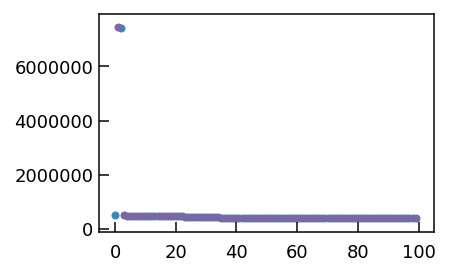

In [30]:
plt.scatter(np.arange(len(nll_after_rvs))*2, nll_after_rvs)
plt.scatter(np.arange(len(nll_after_rvs))*2 + 1, nll_after_model)

[-0.04233933 -0.04233933 -0.04233933 ... -0.03436115 -0.03436115
 -0.03436115]


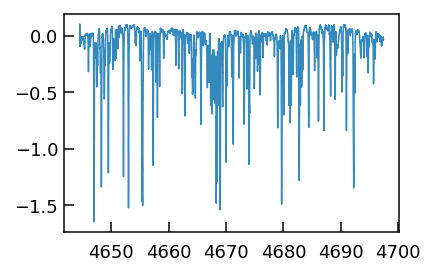

In [31]:
print params_model
plt.step(np.exp(model_xs), params_model)

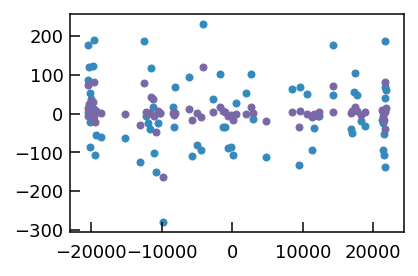

In [32]:
plt.scatter(pipeline_rvs, starting_rvs - pipeline_rvs)
plt.scatter(pipeline_rvs, params_rvs - pipeline_rvs)

In [33]:
np.std(params_rvs - pipeline_rvs)

33.59366064817992

In [34]:
np.std(pipeline_rvs - a.bervs)

4.068212973671707